In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os, itertools
import scipy.stats as stat
from sklearn.cluster import KMeans


# Function to create modular graph


In [189]:
def create_adjacency_matrix_for_modular_graph(num_nodes, num_modules, module_sizes, inter_module_edges, boundary_nodes):
  """
  Creates an adjacency matrix for a graph with modular structure.

  Args:
    num_nodes: The total number of nodes in the graph.
    num_modules: The number of modules in the graph.
    module_sizes: A list of the sizes of each module.
    inter_module_edges: A list of edges between modules.

  Returns:
    An adjacency matrix for the graph.
  """

  # Create an empty adjacency matrix.
  adj_matrix = np.zeros((num_nodes, num_nodes))

  # Add edges within each module.
  for module_index in range(num_modules):
    module_start_index = sum(module_sizes[:module_index])
    module_end_index = module_start_index + module_sizes[module_index]

    for node_index in range(module_start_index, module_end_index):
      for other_node_index in range(module_start_index, module_end_index):
        if node_index != other_node_index:
          adj_matrix[node_index, other_node_index] = 1
        
  for node_i in boundary_nodes:
    for node_j in boundary_nodes:
      adj_matrix[node_i][node_j] = 0

  # Add edges between modules.
  for edge in inter_module_edges:
    node_index_1, node_index_2 = edge
    adj_matrix[node_index_1, node_index_2] = 1
    adj_matrix[node_index_2, node_index_1] = 1

  return adj_matrix


modular_graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])

# Function to plot a graph

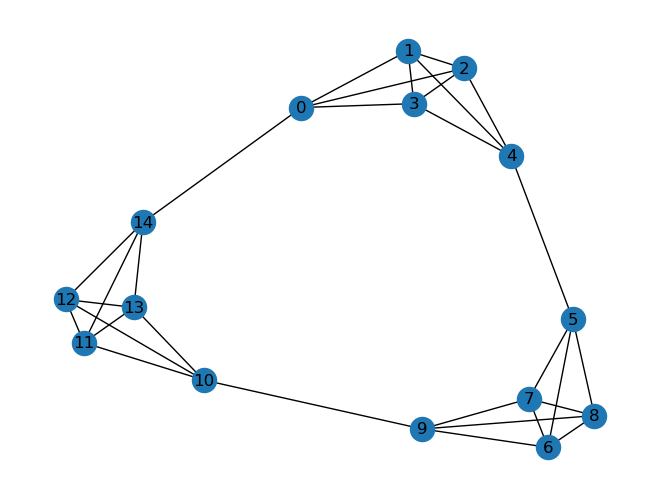

In [190]:
def plot_graph(graph):
    G = nx.Graph() 
    for i in range(graph.shape[0]):
        for j in range(graph.shape[1]):
            if graph[i][j]:
                G.add_edge(i, j)

    nx.draw(G, with_labels = True)
    plt.show()

plot_graph(modular_graph)

# Functions for walks

In [191]:
def random_walk(graph, path_length = 1000):
    #Random Walk
    start_state = np.random.choice(range(graph.shape[0]))
    current_state = start_state
    path = np.zeros(path_length)
    for i in range(path_length):
        path[i] = current_state
        neighbour_states = np.where(graph[current_state])[0]
        next_state = np.random.choice(neighbour_states)
        current_state = next_state
    return path
        

def random_hop(graph, hop_step = 1, path_length = 1000):
    #Random Walk
    start_state = np.random.choice(range(graph.shape[0]))
    current_state = start_state
    path = np.zeros(path_length)

    for i in range(path_length):

        if i%hop_step == 0:
            start_state = np.random.choice(range(graph.shape[0]))
            current_state = start_state

        neighbour_states = np.where(graph[current_state])[0]
        next_state = np.random.choice(neighbour_states)
        path[i] = current_state
        current_state = next_state

    return path


In [192]:
def run_SR(path, graph, alpha = 0.1, gamma = 0.1, plot = True):
    SR = np.random.uniform(0, 1, size=graph.shape)
    num_nodes = modular_graph.shape[0]
    start_state = np.random.choice(np.arange(num_nodes))
    current_state = start_state    


    for observed_state in path:

        expected_probs = SR[current_state]
        one_hot_obs = np.zeros(num_nodes)
        one_hot_obs[int(observed_state)] = 1

        SR_delta = one_hot_obs + gamma*SR[int(observed_state), :] - expected_probs

        SR[current_state, :] = SR[current_state, :] + alpha*SR_delta
        SR[current_state, :] = SR[current_state, :]/sum(SR[current_state])
        current_state = int(observed_state)

    if plot:
        sns.heatmap(SR)
    return SR

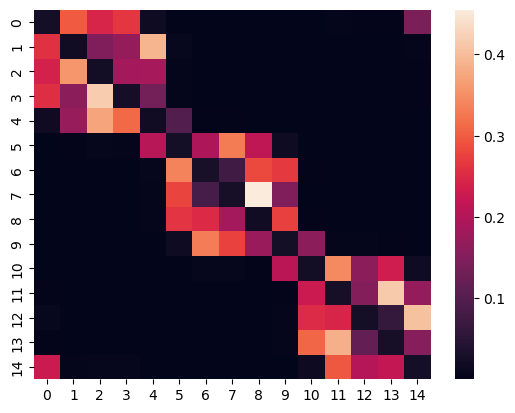

In [193]:
SR = run_SR(random_walk(modular_graph), modular_graph)
# plt.title('hop size: 6')

In [194]:
def compute_node_entropies(params):
    alpha = params[0]
    gamma = params[1]
    num_nodes = 15
    num_modules = 3
    boundary_nodes = [x for x in range(num_nodes) if ((x%5 == 0) or (x%5 == 4))]
    crossmodule_connections = [(0, 14), (4, 5), (9, 10)]
    node_entropy = np.zeros(num_nodes)

    graph = create_adjacency_matrix_for_modular_graph(num_nodes, num_modules, np.repeat(num_nodes//num_modules, num_modules), 
                                                      crossmodule_connections, boundary_nodes)
    if len(params)>2:
        if params[2] == 'hop':
            SR = run_SR(path=random_hop(graph, hop_step=params[3]), graph=graph, alpha=alpha, gamma=gamma, plot=False)
        else:
            SR = run_SR(path=random_walk(graph), graph=graph, alpha=alpha, gamma=gamma, plot=False)

            

    # graph_entropy = -np.sum(SR*np.log(SR))
    for node in range(graph.shape[0]):
        node_entropy[node] = -np.sum(SR[node]*np.log(SR[node]))

    return node_entropy


# Functions for encoding stimuli

In [396]:
def get_stimset(mean_a, mean_b, mean_c):
    pts_a = np.random.multivariate_normal([0, .5], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    pts_b = np.random.multivariate_normal([.25, 0], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    pts_c = np.random.multivariate_normal([-.25, 0], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    overall_set = np.row_stack([pts_a, pts_b, pts_c])

    return pts_a, pts_b, pts_c, overall_set



def plot_stimset(pts_a, pts_b, pts_c):
    plt.plot(pts_a[:, 0], pts_a[:, 1], '.', alpha=0.5)
    plt.plot(pts_b[:, 0], pts_b[:, 1], '.', alpha=0.5)
    plt.plot(pts_c[:, 0], pts_c[:, 1], '.', alpha=0.5)

    plt.axis('equal')
    plt.grid()
    plt.show()

def get_stimpresented(pts_a, pts_b, pts_c):

    obj_feature_matrix = np.row_stack([pts_a[np.random.choice(np.arange(pts_a.shape[0]), size=5, replace=False)], 
                                    pts_b[np.random.choice(np.arange(pts_b.shape[0]), size=5, replace=False)], 
                                    pts_c[np.random.choice(np.arange(pts_c.shape[0]), size=5, replace=False)]])
    return obj_feature_matrix

def get_encoded(store_prob, acc_prob, encode_noise, stim_stream, obj_cat_feature_matrix):
    encoder = np.zeros((len(stim_stream), obj_cat_feature_matrix.shape[1]))
    # forgetting_rate = 0.05
    # encoding_rate = 0.9
    for i, stim in enumerate(stim_stream):
        for feature in range(obj_cat_feature_matrix.shape[1]):
            if np.random.uniform() < store_prob:
                if np.random.uniform() < acc_prob:
                    encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                else:
                    encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
            else:
                encoder[i][feature] = 0

    return encoder
            
            

# Recognition Memory Test

In [310]:
def recognition(test_item, encoder, c = .1, match_sd = .1, weights = np.array([.5, .5]), criterion = 1300):

    memory_match_trace = 0
    
    for e in encoder:
        memory_match_trace += np.exp(c*(np.sqrt(weights[0]*(test_item[0] - e[0])**2 + weights[1]*(test_item[1] - e[1])**2))) + np.random.normal(0, match_sd)

    if memory_match_trace > criterion:
        return True
    else:
        return False        


In [454]:
stim_stream = random_walk(modular_graph).astype(int)
SR = run_SR(stim_stream, modular_graph, plot=False)
pts_a, pts_b, pts_c, all_objs = get_stimset([0, .5], [.25, 0], [-.25, 0])
objects = get_stimpresented(pts_a, pts_b, pts_c)
encoder = get_encoded(0.9, 1, .01, stim_stream, objects)
# sns.heatmap(encoder)

old_test_item = objects[np.random.choice(np.arange(objects.shape[0]))]
new_test_item = all_objs[np.random.choice(np.arange(all_objs.shape[0]))]

recognition(new_test_item, encoder, criterion=1030)

True

(3049.4039532848647, 3121.3846213081033)

In [198]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(encoder)
# kmeans.labels_
predicted = kmeans.predict(encoder)
predicted

c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

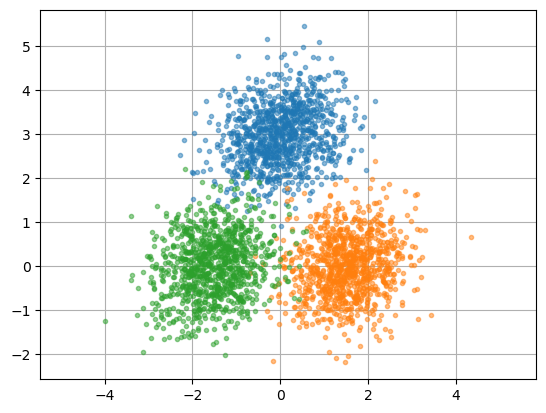